## Image Preprocessing
Progam of helper functions for image preprocessing.

In [1]:
# Import libraries
import os
import shutil
import time
import random
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
# Enable GPU processing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device type: {device}')

Device type: cuda


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [4]:
# Set random seed
seed = 777
torch.manual_seed(seed)

In [5]:
# Get image class/subdirectory names
datadir = '/drive/My Drive/Data/flowers-base/'
dirnames = []
for dir_path, dir_names, file_names in os.walk(datadir):
  for dir in dir_names:
    dirnames.append(dir)
print(dirnames)

['tulip', 'rose', 'sunflower', 'daisy']


In [6]:
# Function to count the number of files in each directory
def dir_counts(datadir, dirnames):
  counts = []
  for i in range(len(dirnames)):
    dirpath = datadir + str(dirnames[i]) + '/'
    quant = len([name for name in os.listdir(dirpath)])
    counts.append(quant)

  # dataframe of categories
  df = pd.DataFrame({'classes': dirnames,'counts': counts}).sort_values('classes')
  
  return df, counts

In [7]:
# Initial file counts per class
df, counts = dir_counts(datadir, dirnames)
print(df)

     classes  counts
3      daisy     510
1       rose     486
2  sunflower     547
0      tulip     746


Text(0.5, 1.0, 'Images by Class')

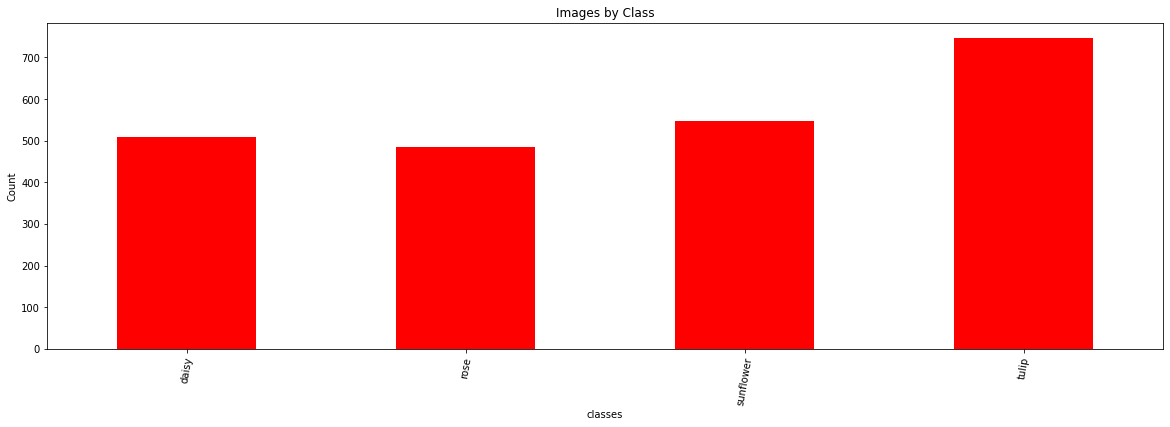

In [8]:
# Review the intial class distribution
df.set_index('classes')['counts'].plot.bar(color='r', figsize=(20, 6))
plt.xticks(rotation=80)
plt.ylabel('Count')
plt.title('Images by Class')

In [9]:
# Create a 'for' loop to level out the number of images per class
level = 600
for i in range(len(dirnames)):
  dirpath = datadir + str(dirnames[i]) + '/'
  if counts[i] < level:
    for j in range(level - counts[i]):
      f = random.choice(os.listdir(dirpath))
      f2 = str(f.split('.')[0]) + '_' + str(j) + '.jpg'
      temp = os.path.join(dirpath, f)
      temp2 = os.path.join(dirpath, f2)
      shutil.copy2(temp, temp2)
  if counts[i] > level:
    for j in range(counts[i] - level):
      f = random.choice(os.listdir(dirpath))
      temp = os.path.join(dirpath, f)
      os.remove(temp)

In [10]:
# Review the updated file counts per class
updated_df, _ = dir_counts(datadir, dirnames)
print(f'Updated file counts per class {updated_df}')

Updated file counts per class      classes  counts
3      daisy     600
1       rose     600
2  sunflower     600
0      tulip     600


Text(0.5, 1.0, 'Images by Class')

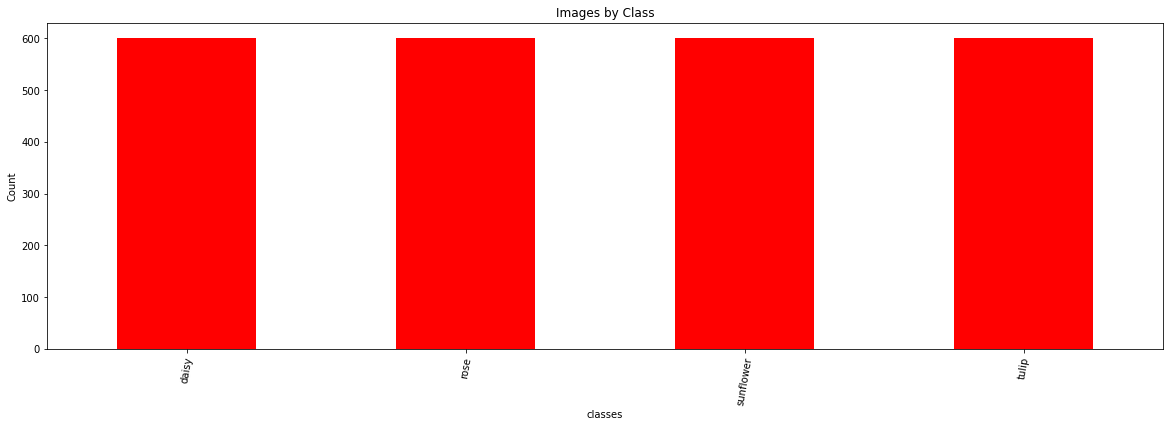

In [11]:
# Review the updated class distribution
updated_df.set_index('classes')['counts'].plot.bar(color='r', figsize=(20, 6))
plt.xticks(rotation=80)
plt.ylabel('Count')
plt.title('Images by Class')

In [12]:
# Load the dataset - transform it into appropriate sized images and convert them to a PyTorch tensor
transform = transforms.Compose([transforms.CenterCrop(224), transforms.ToTensor()])
raw_data = datasets.ImageFolder(root=datadir, transform=transform)
print(f'Dataset classes: {raw_data.classes}')

Dataset classes: ['daisy', 'rose', 'sunflower', 'tulip']


In [14]:
# Review image data
x, y = raw_data[1250]
print(y)
print(x)

2
tensor([[[0.7569, 0.7529, 0.7529,  ..., 0.7255, 0.7373, 0.7373],
         [0.7647, 0.7608, 0.7569,  ..., 0.7333, 0.7373, 0.7373],
         [0.7412, 0.7373, 0.7412,  ..., 0.7373, 0.7373, 0.7373],
         ...,
         [0.5725, 0.7059, 0.7412,  ..., 0.4118, 0.3412, 0.3451],
         [0.6745, 0.7137, 0.7176,  ..., 0.4980, 0.3922, 0.3255],
         [0.7608, 0.7098, 0.7059,  ..., 0.2941, 0.4784, 0.3137]],

        [[0.8275, 0.8235, 0.8196,  ..., 0.7961, 0.7843, 0.7843],
         [0.8353, 0.8314, 0.8275,  ..., 0.7961, 0.7882, 0.7882],
         [0.8235, 0.8196, 0.8235,  ..., 0.7961, 0.7843, 0.7843],
         ...,
         [0.7020, 0.8157, 0.8353,  ..., 0.5176, 0.4392, 0.4431],
         [0.8000, 0.8235, 0.8078,  ..., 0.6078, 0.5137, 0.4471],
         [0.8902, 0.8157, 0.7882,  ..., 0.4039, 0.6078, 0.4471]],

        [[0.9216, 0.9176, 0.9216,  ..., 0.8824, 0.8706, 0.8706],
         [0.9137, 0.9098, 0.9059,  ..., 0.8863, 0.8627, 0.8627],
         [0.8902, 0.8863, 0.8902,  ..., 0.8784, 0.8706, 

In [16]:
# Calculate the mean and standard deviation per color channel for normalizing the images
def norm_images(data, batch_size):
  loader = DataLoader(data, batch_size=batch_size, num_workers=1)
  nimages = 0
  mean = 0.
  std = 0.
  for batch, _ in loader:
      # Rearrange batch to be the shape of [B, C, W * H]
      batch = batch.view(batch.size(0), batch.size(1), -1)
      # Update total number of images
      nimages += batch.size(0)
      # Compute mean and std here
      mean += batch.mean(2).sum(0) 
      std += batch.std(2).sum(0)

  
  mean /= nimages
  std /= nimages

  return mean, std

In [17]:
# Image mean and standard deviation per channel for image normalization
mean, std = norm_images(raw_data, 200 )
print(f'The image mean across the color channels: {mean}')
print(f'The image standard deviation across the color channels: {std}')

The image mean across the color channels: tensor([0.4944, 0.4133, 0.2910])
The image standard deviation across the color channels: tensor([0.2694, 0.2364, 0.2378])
